In [ ]:
 !pip install -U "ray[data,train,tune,serve]"
 !pip install neuralforecast

"""
https://github.com/Nixtla/neuralforecast/issues/943

Go /usr/local/lib/python3.10/dist-packages/neuralforecast/models/tft.py

Change

 self.stat_exog_list = [] if stat_exog_list is None else stat_exog_list
 self.hist_exog_list = [] if hist_exog_list is None else hist_exog_list
 self.futr_exog_list = [] if futr_exog_list is None else futr_exog_list

into
 self.futr_exog_list = list(futr_exog_list) if futr_exog_list is not None else []
 self.hist_exog_list = list(hist_exog_list) if hist_exog_list is not None else []
 self.stat_exog_list = list(stat_exog_list) if stat_exog_list is not None else []




Also
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py
Change line 55 into:

set(temporal_cols.tolist()) & set(list(self.hist_exog_list) + list(self.futr_exog_list))

"""

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

'\nhttps://github.com/Nixtla/neuralforecast/issues/943\n\nGo /usr/local/lib/python3.10/dist-packages/neuralforecast/models/tft.py\n\nChange\n\nself.stat_exog_list = [] if stat_exog_list is None else stat_exog_list\nself.hist_exog_list = [] if hist_exog_list is None else hist_exog_list\nself.futr_exog_list = [] if futr_exog_list is None else futr_exog_list\n\ninto\nself.futr_exog_list = list(futr_exog_list) if futr_exog_list is not None else []\nself.hist_exog_list = list(hist_exog_list) if hist_exog_list is not None else []\nself.stat_exog_list = list(stat_exog_list) if stat_exog_list is not None else []\n\n\n\n\nAlso\n/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py\nChange line 55 into:\n\nset(temporal_cols.tolist()) & set(list(self.hist_exog_list) + list(self.futr_exog_list))\n\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS
from neuralforecast.losses.pytorch import MSE, MAE

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/coin_Bitcoin.csv', parse_dates=['Date'])
df_hist = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/coin_Bitcoin.csv', parse_dates=['Date'])

df['Date'] = pd.to_datetime(df['Date'])
df_hist['Date'] = pd.to_datetime(df_hist['Date'])
df = df.drop(columns=['SNo', 'Name', 'Symbol'])
df_hist = df_hist.drop(columns=['SNo', 'Name', 'Symbol'])

df.rename(columns={"Date":"ds"}, inplace=True)
df_hist.rename(columns={"Date":"ds"}, inplace=True)

df_hist_copy = df_hist.copy()

df_hist = df_hist.drop(columns=['Open', 'High', 'Low', 'Volume', 'Marketcap'])
df_hist = df_hist.melt(id_vars=['ds'], var_name='unique_id', value_name='y')

df_hist['Open'] = df_hist_copy['Open']
df_hist['High'] = df_hist_copy['High']
df_hist['Low'] = df_hist_copy['Low']
df_hist['Volume'] = df_hist_copy['Volume']
df_hist['Marketcap'] = df_hist_copy['Marketcap']
df_hist['Close'] = df_hist_copy['Close']

df = df.melt(id_vars=['ds'], var_name='unique_id', value_name='y')
n_time = len(df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.1 * n_time)

# df = df.set_index('Date')
# df =df.drop(columns=['Name','Symbol'])
# df, df.describe(), df["y"].plot()
df, df_hist

(                       ds  unique_id             y
 0     2013-04-29 23:59:59       High  1.474880e+02
 1     2013-04-30 23:59:59       High  1.469300e+02
 2     2013-05-01 23:59:59       High  1.398900e+02
 3     2013-05-02 23:59:59       High  1.256000e+02
 4     2013-05-03 23:59:59       High  1.081280e+02
 ...                   ...        ...           ...
 17941 2021-07-02 23:59:59  Marketcap  6.354508e+11
 17942 2021-07-03 23:59:59  Marketcap  6.499397e+11
 17943 2021-07-04 23:59:59  Marketcap  6.615748e+11
 17944 2021-07-05 23:59:59  Marketcap  6.326962e+11
 17945 2021-07-06 23:59:59  Marketcap  6.418992e+11
 
 [17946 rows x 3 columns],
                       ds unique_id             y          Open          High  \
 0    2013-04-29 23:59:59     Close    144.539993    134.444000    147.488007   
 1    2013-04-30 23:59:59     Close    139.000000    144.000000    146.929993   
 2    2013-05-01 23:59:59     Close    116.989998    139.000000    139.889999   
 3    2013-05-02 23:59:

# Testing the TSMixer Usage in the Library

In [ ]:
horizon = 5
input_size = 300
models = [
          TSMixer(h=horizon,
                input_size=input_size,
                n_series=6,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='standard',
                valid_loss=MAE(),
                random_seed=12345678,
                ),
         ]

nf = NeuralForecast(models=models,freq="1B")

df_hat = nf.cross_validation(df=df,
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None
                              )

df_hat = df_hat.reset_index()

TSMixer horizon 5 - MAE: 10194282060.906
TSMixer horizon 5 - MSE: 1008118607752888188928.000


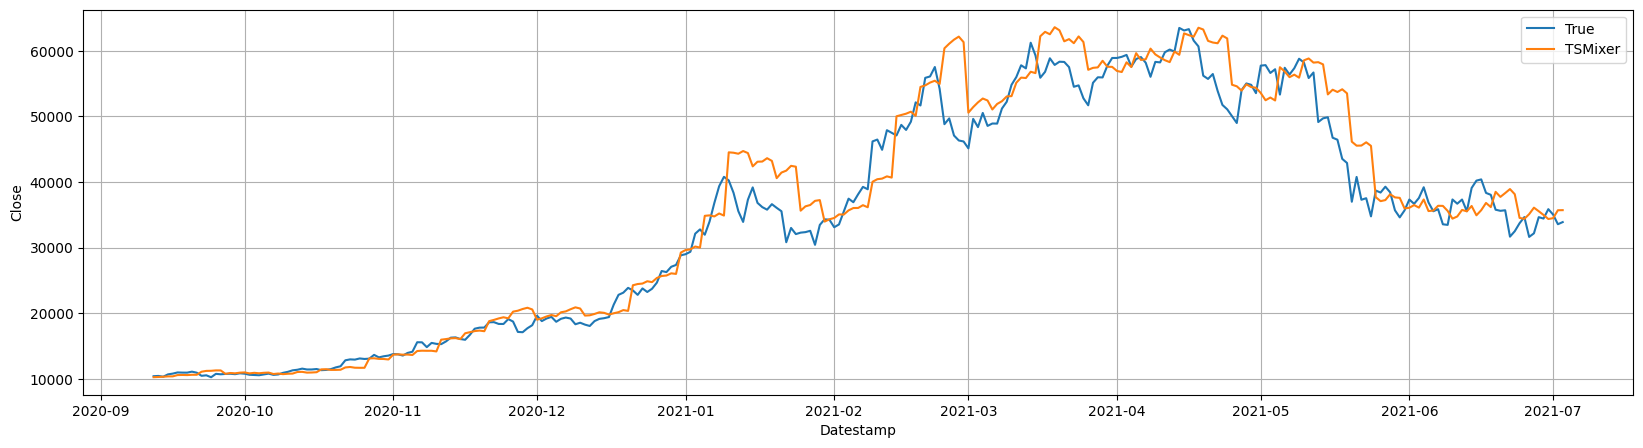

In [ ]:
from neuralforecast.losses.numpy import mse, mae


Y_plot = df_hat[df_hat['unique_id']=='Close']
cutoffs = df_hat['cutoff'].unique()[::horizon]
Y_plot = Y_plot[df_hat['cutoff'].isin(cutoffs)]

mae_tsmixer = mae(df_hat['y'], df_hat['TSMixer'])
mse_tsmixer = mse(df_hat['y'], df_hat['TSMixer'])
print(f'TSMixer horizon {horizon} - MAE: {mae_tsmixer:.3f}')
print(f'TSMixer horizon {horizon} - MSE: {mse_tsmixer:.3f}')


plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['TSMixer'], label='TSMixer')
plt.xlabel('Datestamp')
plt.ylabel('Close')
plt.grid()
plt.legend()


# Hyperparamerters Tuning for All The Models

In [ ]:
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.auto import AutoTSMixer, AutoTFT, AutoLSTM, AutoTCN
from neuralforecast.losses.numpy import mse, mae

horizon = 5 # prediction length

TFT_config = {
    "input_size": tune.choice([20, 30, 60, 90, 150, 300]),
    # "h": horizon,
    "hidden_size": tune.choice([64, 128]),
    "learning_rate": tune.loguniform(1e-5, 1e-2),
    "max_steps": tune.choice([ 1000]),
    "batch_size": tune.choice([16, 32]),
    "scaler_type": 'standard',
    "hist_exog_list": ['Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'],
    "val_check_steps": 100,                                                   # Compute validation every x steps
    "early_stop_patience_steps": 5
}

LSTM_config = {
    # "input_size": tune.choice([15, 30, 60, 90, 150, 300]),
    # "context_size": tune.choice([5, 15, 30, 90, 200]),
    # "inference_input_size": tune.choice([5, 15, 30, 90, 200]),

    "encoder_hidden_size": tune.choice([20, 50, 100, 200]),
    "encoder_n_layers": tune.choice([2, 3, 4]),
    "decoder_hidden_size": tune.choice([30, 64, 128, 200]),
    "decoder_layers": tune.choice([2, 3, 4]),
    "learning_rate": tune.loguniform(1e-5, 1e-2),
    "max_steps": tune.choice([ 1000]),
    "batch_size": tune.choice([16, 32]),
    "scaler_type": 'standard',
    "hist_exog_list": ['Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'],
    "val_check_steps": 100,                                                   # Compute validation every x steps
    "early_stop_patience_steps": 5
}

TCN_config = {
    "encoder_hidden_size": tune.choice([20, 50, 100, 200]),
    "context_size": tune.choice([5, 10, 50]),
    "decoder_hidden_size": tune.choice([64, 128]),
    "learning_rate": tune.loguniform(1e-5, 1e-1),
    "max_steps": tune.choice([500, 1000]),
    "batch_size": tune.choice([16, 32]),
}

tsmixer_config = {
    # "h": tune.choice([96,192]),
    "input_size": tune.choice([15, 20, 30, 60, 90, 150, 300]),
    "max_steps": tune.choice([500, 1000]),                             
    "val_check_steps": 100,                                            
    "early_stop_patience_steps": 5,                                    
    "learning_rate": tune.loguniform(1e-5, 1e-2),                      
    "n_block": tune.choice([1, 2, 4, 6, 8]),                           
    "dropout": tune.choice([0.1, 0.3, 0.5, 0.9]),                      
    "ff_dim": tune.choice([32, 64, 128]),                              
    "scaler_type": 'standard',
    "n_series": 6
}



model_TFT = AutoTFT(
    h = horizon,
    loss=MSE(),
    config=TFT_config,
    num_samples=10,
    search_alg=HyperOptSearch(),
    backend='ray',
    valid_loss = MSE(),
)

model_LSTM = AutoLSTM(
    h=horizon,
    loss=MSE(),
    config=LSTM_config,
    num_samples=10,
    search_alg=HyperOptSearch(),
    backend='ray',
    valid_loss = MSE(),
)

model_TCN = AutoTCN(
    h = horizon,
    loss=MSE(),
    config = TCN_config,
    num_samples=10,
    search_alg=HyperOptSearch(),
    backend='ray',
    valid_loss = MSE(),
)
# tsmixerx_config = tsmixer_config.copy()
model = AutoTSMixer(h=horizon,
                    n_series=6,
                    loss=MSE(),
                    config=tsmixer_config,
                    num_samples=10,
                    search_alg=HyperOptSearch(),
                    backend='ray',
                    valid_loss=MSE())

nf = NeuralForecast(models=[model], freq='D')
nf_hist = NeuralForecast(models=[model_TFT, model_TCN], freq='D')

df_hat_hist = nf_hist.cross_validation(df=df_hist, val_size=val_size,test_size=test_size, n_windows=None)
df_hat = nf.cross_validation(df=df, val_size=val_size,test_size=test_size, n_windows=None)

print(nf.models[0].results.get_best_result().config) # TSMIxer

for model in nf_hist.models:
    print(model.results.get_best_result().config)




/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
2024-04-15 11:31:13,669	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-15_11-31-13   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-15_11-31-13
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-15_09-24-41_765139_1296/artifacts/2024-04-15_11-31-13/_train_tune_2024-04-15_11-31-13/driver_artifacts`


(_train_tune pid=40992) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=40992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=40992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=40992) Seed set to 1
(_train_tune pid=40992) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=40992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=40992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, v_num=0, train_loss_step=2.880, train_loss_epoch=2.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s, v_num=0, train_loss_step=2.340, train_loss_epoch=2.630, valid_loss=4.02e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s, v_num=0, train_loss_step=2.260, train_loss_epoch=1.950, valid_loss=3.45e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s, v_num=0, train_loss_step=2.140, train_loss_epoch=2.160, valid_loss=3.28e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s, v_num=0, train_loss_step=2.280, train_loss_epoch=2.110, valid_loss=3.25e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.91it/s]
(_train_tune pid=40992) 
Epoch 599: 100%|██████████| 1/

(_train_tune pid=40992) `Trainer.fit` stopped: `max_steps=1000` reached.
2024-04-15 11:32:31,595	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s, v_num=0, train_loss_step=1.510, train_loss_epoch=1.620, valid_loss=3.75e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s, v_num=0, train_loss_step=1.510, train_loss_epoch=1.510, valid_loss=4e+5]


(_train_tune pid=41369) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=41369) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=41369) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=41369) Seed set to 1
(_train_tune pid=41369) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=41369) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=41369) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s, v_num=0, train_loss_step=2.120, train_loss_epoch=1.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.330, valid_loss=3.51e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=41369) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.58it/s]
(_train_tune pid=41369) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s, v_num=0, train_loss_step=0.652, train_loss_epoch=0.601, valid_loss=3.69e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s, v_num=0, train_loss_step=0.420, train_loss_epoch=0.442, valid_loss=4.16e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=41369) 
Epoch 499: 100%|██████████| 1/1 [

2024-04-15 11:33:23,063	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.274, valid_loss=4.8e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.266, valid_loss=5.04e+5]


(_train_tune pid=41631) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=41631) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=41631) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=41631) Seed set to 1
(_train_tune pid=41631) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=41631) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=41631) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, v_num=0, train_loss_step=2.030, train_loss_epoch=1.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s, v_num=0, train_loss_step=1.570, train_loss_epoch=1.970, valid_loss=4.71e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s, v_num=0, train_loss_step=1.320, train_loss_epoch=1.470, valid_loss=3.82e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s, v_num=0, train_loss_step=1.380, train_loss_epoch=1.280, valid_loss=3.08e+5]
(_train_tune pid=41631) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=41631) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=41631) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, v_num=0, train_loss_step=1.360, train_loss_epoch=1.300, valid_loss=2.99e+5]
(_train_tune pid=41631) 
Validatio

2024-04-15 11:36:22,859	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=41631) `Trainer.fit` stopped: `max_steps=1000` reached.


(_train_tune pid=41631) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, v_num=0, train_loss_step=1.150, train_loss_epoch=1.150, valid_loss=3.06e+5]


(_train_tune pid=42454) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=42454) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=42454) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=42454) Seed set to 1
(_train_tune pid=42454) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=42454) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=42454) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s, v_num=0, train_loss_step=0.174, train_loss_epoch=0.191]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=42454) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s, v_num=0, train_loss_step=0.139, train_loss_epoch=0.150, valid_loss=4.01e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=42454) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s, v_num=0, train_loss_step=0.0969, train_loss_epoch=0.0881, valid_loss=8.75e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=42454) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s, v_num=0, train_loss_step=0.0542, train_loss_epoch=0.0532, valid_loss=1.08e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|       

2024-04-15 11:40:28,803	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s, v_num=0, train_loss_step=0.0344, train_loss_epoch=0.0302, valid_loss=1.11e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=42454) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]
(_train_tune pid=42454) 
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, v_num=0, train_loss_step=0.0344, train_loss_epoch=0.0344, valid_loss=9.94e+5]


(_train_tune pid=43566) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=43566) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=43566) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=43566) Seed set to 1
(_train_tune pid=43566) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=43566) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=43566) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s, v_num=0, train_loss_step=0.287, train_loss_epoch=0.273]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=43566) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, v_num=0, train_loss_step=0.151, train_loss_epoch=0.165, valid_loss=3.45e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=43566) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s, v_num=0, train_loss_step=0.0839, train_loss_epoch=0.0848, valid_loss=6.45e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=43566) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s, v_num=0, train_loss_step=0.0593, train_loss_epoch=0.0551, valid_loss=7.29e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|       

2024-04-15 11:45:15,029	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=44851) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=44851) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=44851) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is alrea

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=44851) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=44851) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=0, train_loss_step=0.164, train_loss_epoch=0.196]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=44851) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, train_loss_step=0.123, train_loss_epoch=0.122, valid_loss=3.36e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=44851) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=0, train_loss_step=0.0675, train_loss_epoch=0.0649, valid_loss=3.85e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=44851) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, train_loss_step=0.035, train_loss_epoch=0.0308, valid_loss=6.1e+5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|        

2024-04-15 11:53:13,155	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=44851) 
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s, v_num=0, train_loss_step=0.0212, train_loss_epoch=0.0212, valid_loss=7.21e+5]


(_train_tune pid=46972) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=46972) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=46972) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=46972) Seed set to 1
(_train_tune pid=46972) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=46972) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=46972) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s, v_num=0, train_loss_step=1.980, train_loss_epoch=1.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s]
(_train_tune pid=46972) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s, v_num=0, train_loss_step=0.951, train_loss_epoch=0.916, valid_loss=3.33e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=46972) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s, v_num=0, train_loss_step=0.423, train_loss_epoch=0.403, valid_loss=4.31e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s, v_num=0, train_loss_step=0.280, train_loss_epoch=0.294, valid_loss=5.94e+5]
(_train_tune pid=46972) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=46972) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s, v_num=0, train

2024-04-15 11:54:41,269	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s, v_num=0, train_loss_step=0.184, train_loss_epoch=0.197, valid_loss=5.3e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s, v_num=0, train_loss_step=0.184, train_loss_epoch=0.184, valid_loss=5.17e+5]


(_train_tune pid=47398) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=47398) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=47398) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=47398) Seed set to 1
(_train_tune pid=47398) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=47398) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=47398) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, v_num=0, train_loss_step=0.282, train_loss_epoch=0.255]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=47398) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]
(_train_tune pid=47398) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.190, valid_loss=3.34e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=47398) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, v_num=0, train_loss_step=0.0734, train_loss_epoch=0.0684, valid_loss=4.98e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, v_num=0, train_loss_step=0.0412, train_loss_epoch=0.0421, valid_loss=5.93e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%

2024-04-15 11:57:13,221	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, v_num=0, train_loss_step=0.0216, train_loss_epoch=0.022, valid_loss=7.29e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=47398) 
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s, v_num=0, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=6.74e+5]


(_train_tune pid=48092) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=48092) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=48092) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=48092) Seed set to 1
(_train_tune pid=48092) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=48092) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=48092) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.760, train_loss_epoch=1.760]


2024-04-15 11:57:28,653	ERROR tune_controller.py:1332 -- Trial task failed for trial _train_tune_f2b602aa
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2667, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 866, in get_objects
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 07171d0e191c8762e

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1883, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1984, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1889, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task.function_executor
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 724, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 334, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.10/dist-packages/ray/air/_internal/util.py", line 88, in run
    self._ret = self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.

(_train_tune pid=48198) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=48198) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=48198) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=48198) Seed set to 1
(_train_tune pid=48198) /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=48198) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=48198) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s, v_num=0, train_loss_step=0.867, train_loss_epoch=0.836]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=48198) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, v_num=0, train_loss_step=0.398, train_loss_epoch=0.378, valid_loss=6.38e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=48198) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, v_num=0, train_loss_step=0.395, train_loss_epoch=0.362, valid_loss=3.22e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=48198) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s, v_num=0, train_loss_step=0.365, train_loss_epoch=0.331, valid_loss=3.26e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          |

2024-04-15 12:04:30,921	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-04-15 12:04:30,969	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-15_11-31-13' in 0.0319s.
2024-04-15 12:04:30,982	ERROR tune.py:1044 -- Trials did not complete: [_train_tune_f2b602aa]


(_train_tune pid=48198) 
Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, v_num=0, train_loss_step=0.315, train_loss_epoch=0.315, valid_loss=3.46e+5]



/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, usin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-15 12:07:26,812	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-15_12-07-26   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-15_12-07-26
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-15_09-24-41_765139_1296/artifacts/2024-04-15_12-07-26/_train_tune_2024-04-15_12-07-26/driver_artifacts`


(_train_tune pid=50807) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=50807) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=50807) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=50807) Seed set to 1
(_train_tune pid=50807) GPU available: True (cuda), used: True
(_train_tune pid=50807) TPU available: False, using:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=50807) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 56.93it/s, v_num=0, train_loss_step=15.10, train_loss_epoch=15.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 85.84it/s, v_num=0, train_loss_step=2.390, train_loss_epoch=2.420, valid_loss=5.46e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 89.01it/s, v_num=0, train_loss_step=1.420, train_loss_epoch=1.420, valid_loss=5.64e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 82.83it/s, v_num=0, train_loss_step=1.180, train_loss_epoch=1.180, valid_loss=4.06e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 91.15it/s, v_num=0, train_loss_step=1.110, train_loss_epoch=1.110, valid_loss=3.67e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 85.51it/s, v_num=0, train_loss_step=1.060, train_loss_epoch=1.060, valid_loss=3.

2024-04-15 12:08:07,732	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=50807) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s, v_num=0, train_loss_step=0.910, train_loss_epoch=0.910, valid_loss=3.85e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s, v_num=0, train_loss_step=0.910, train_loss_epoch=0.910, valid_loss=3.85e+5]


(_train_tune pid=51021) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=51021) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=51021) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=51021) Seed set to 1
(_train_tune pid=51021) GPU available: True (cuda), used: True
(_train_tune pid=51021) TPU available: False, using:

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=51021) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 93.18it/s, v_num=0, train_loss_step=103.0, train_loss_epoch=103.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=51021) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 91.56it/s, v_num=0, train_loss_step=40.50, train_loss_epoch=41.80, valid_loss=6.2e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 91.17it/s, v_num=0, train_loss_step=5.700, train_loss_epoch=5.710, valid_loss=2.28e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 85.81it/s, v_num=0, train_loss_step=4.160, train_loss_epoch=4.180, valid_loss=1.15e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 92.97it/s, v_num=0, train_loss_step=2.600, train_loss_epoch=2.610, valid_loss=8.51e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<

2024-04-15 12:08:47,221	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 67.24it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.250, valid_loss=3.77e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.250, valid_loss=3.79e+5]


(_train_tune pid=51021) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=51230) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=51230) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=51230) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=51230) Seed set to 1
(_train_tune pid=51230) GPU available: Tru

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=51230) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 83.46it/s, v_num=0, train_loss_step=91.90, train_loss_epoch=92.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s, v_num=0, train_loss_step=6.500, train_loss_epoch=6.560, valid_loss=5.49e+7]
(_train_tune pid=51230) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 52.54it/s, v_num=0, train_loss_step=3.850, train_loss_epoch=3.870, valid_loss=1.54e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 50.55it/s, v_num=0, train_loss_step=2.260, train_loss_epoch=2.270, valid_loss=8.47e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 484:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.800, train_loss_epoch=1.800, valid_loss=5.43e+5]


2024-04-15 12:09:21,304	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 497: 100%|██████████| 1/1 [00:00<00:00, 71.53it/s, v_num=0, train_loss_step=1.750, train_loss_epoch=1.750, valid_loss=5.43e+5]


(_train_tune pid=51230) `Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 82.65it/s, v_num=0, train_loss_step=1.740, train_loss_epoch=1.740, valid_loss=5.43e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 30.12it/s, v_num=0, train_loss_step=1.740, train_loss_epoch=1.740, valid_loss=4.26e+5]


(_train_tune pid=51410) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=51410) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=51410) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=51410) Seed set to 1
(_train_tune pid=51410) GPU available: True (cuda), used: True
(_train_tune pid=51410) TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=51410) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 81.73it/s, v_num=0, train_loss_step=1.270, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 85.50it/s, v_num=0, train_loss_step=1.110, train_loss_epoch=1.110, valid_loss=3.45e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 63.55it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.020, valid_loss=3.61e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.71it/s]
(_train_tune pid=51410) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 84.01it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.150, valid_loss=3.8e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.50it/s]
(_train_tune pid=51410) 
Epoch 482:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.964, train_loss_epoch=0.964, valid_l

2024-04-15 12:09:50,643	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 496:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.939, train_loss_epoch=0.939, valid_loss=4.54e+5]


(_train_tune pid=51410) `Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 91.92it/s, v_num=0, train_loss_step=0.920, train_loss_epoch=0.910, valid_loss=4.54e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 31.56it/s, v_num=0, train_loss_step=0.920, train_loss_epoch=0.920, valid_loss=4.18e+5]


(_train_tune pid=51578) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=51578) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=51578) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=51578) Seed set to 1
(_train_tune pid=51578) GPU available: True (cuda), used: True
(_train_tune pid=51578) TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=51578) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 67.97it/s, v_num=0, train_loss_step=104.0, train_loss_epoch=104.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 78.18it/s, v_num=0, train_loss_step=48.80, train_loss_epoch=50.10, valid_loss=6.23e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 98.38it/s, v_num=0, train_loss_step=6.470, train_loss_epoch=6.500, valid_loss=2.79e+7] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 119.29it/s, v_num=0, train_loss_step=4.430, train_loss_epoch=4.450, valid_loss=1.43e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 432: 100%|██████████| 1/1 [00:00<00:00, 95.75it/s, v_num=0, train_loss_step=3.860, train_loss_epoch=3.860, valid_loss=9.42e+5] 
Epoch 433: 100%|██████████| 1/1 [00:00<00:00, 42.05it/s, v_num=0, trai
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 111.79it/s, v_num=0, train_loss_step=2.850, train_lo

2024-04-15 12:10:17,576	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=51578) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 124.54it/s, v_num=0, train_loss_step=1.260, train_loss_epoch=1.260, valid_loss=3.94e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 35.50it/s, v_num=0, train_loss_step=1.260, train_loss_epoch=1.260, valid_loss=3.84e+5]


(_train_tune pid=51730) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=51730) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=51730) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=51730) Seed set to 1
(_train_tune pid=51730) GPU available: True (cuda), used: True
(_train_tune pid=51730) TPU available: False, using:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                                                                           
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=51730) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 74.54it/s, v_num=0, train_loss_step=80.20, train_loss_epoch=81.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s, v_num=0, train_loss_step=5.450, train_loss_epoch=5.480, valid_loss=4.75e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.32it/s]
(_train_tune pid=51730) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 88.77it/s, v_num=0, train_loss_step=2.960, train_loss_epoch=2.980, valid_loss=1.13e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 55.22it/s, v_num=0, train_loss_step=1.930, train_loss_epoch=1.940, valid_loss=6.8e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 488:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.570, train_loss_epoch=1.570, valid_loss=4.71e+5]


2024-04-15 12:10:39,049	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 72.78it/s, v_num=0, train_loss_step=1.530, train_loss_epoch=1.530, valid_loss=4.71e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 27.44it/s, v_num=0, train_loss_step=1.530, train_loss_epoch=1.530, valid_loss=3.89e+5]


(_train_tune pid=51730) `Trainer.fit` stopped: `max_steps=500` reached.
(_train_tune pid=51866) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=51866) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=51866) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=51866) Seed set to 1
(_train_tune pid=51866) GPU available: True

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=51866) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 73.93it/s, v_num=0, train_loss_step=3.500, train_loss_epoch=3.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 119.58it/s, v_num=0, train_loss_step=1.130, train_loss_epoch=1.140, valid_loss=7.6e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=51866) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.12it/s]
(_train_tune pid=51866) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 92.62it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.010, valid_loss=3.58e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 86.58it/s, v_num=0, train_loss_step=0.949, train_loss_epoch=0.949, valid_loss=3.93e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 487:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.887, train_loss_epoch=0.887, valid_loss=4.24

2024-04-15 12:10:59,100	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 114.91it/s, v_num=0, train_loss_step=0.855, train_loss_epoch=0.862, valid_loss=4.24e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 41.06it/s, v_num=0, train_loss_step=0.855, train_loss_epoch=0.855, valid_loss=4.28e+5]


(_train_tune pid=51866) `Trainer.fit` stopped: `max_steps=500` reached.
(_train_tune pid=51991) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=51991) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=51991) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=51991) Seed set to 1
(_train_tune pid=51991) GPU available: True

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=51991) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 107.08it/s, v_num=0, train_loss_step=5.660, train_loss_epoch=5.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 84.36it/s, v_num=0, train_loss_step=2.230, train_loss_epoch=2.250, valid_loss=1.13e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.42it/s]
(_train_tune pid=51991) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 111.79it/s, v_num=0, train_loss_step=1.340, train_loss_epoch=1.350, valid_loss=5.37e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 87.02it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=1.050, valid_loss=3.67e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 69.76it/s, v_num=0, train_loss_step=0.969, train_loss_epoch=0.971, valid_loss=3.62e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   

(_train_tune pid=51991) `Trainer.fit` stopped: `max_steps=1000` reached.
2024-04-15 12:11:28,150	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 103.16it/s, v_num=0, train_loss_step=0.811, train_loss_epoch=0.811, valid_loss=4.41e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s, v_num=0, train_loss_step=0.811, train_loss_epoch=0.811, valid_loss=4.52e+5]


(_train_tune pid=52154) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=52154) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=52154) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=52154) Seed set to 1
(_train_tune pid=52154) GPU available: True (cuda), used: True
(_train_tune pid=52154) TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=52154) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 123.70it/s, v_num=0, train_loss_step=100.0, train_loss_epoch=100.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 86.73it/s, v_num=0, train_loss_step=45.70, train_loss_epoch=46.90, valid_loss=6.02e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 124.03it/s, v_num=0, train_loss_step=7.310, train_loss_epoch=7.340, valid_loss=2.57e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 34.39it/s, v_num=0, train_loss_step=5.000, train_loss_epoch=5.020, valid_loss=1.41e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=52154) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=52154) 
Epoch 483:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=3.260, train_loss_epoch=3.260, valid_loss=8.91e+5]


2024-04-15 12:11:49,005	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=3.020, train_loss_epoch=3.020, valid_loss=8.91e+5]


(_train_tune pid=52154) `Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s, v_num=0, train_loss_step=3.000, train_loss_epoch=3.020, valid_loss=8.91e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s, v_num=0, train_loss_step=3.000, train_loss_epoch=3.000, valid_loss=6.28e+5]


(_train_tune pid=52283) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=52283) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=52283) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=52283) Seed set to 1
(_train_tune pid=52283) GPU available: True (cuda), used: True
(_train_tune pid=52283) TPU available: False, using:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=52283) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s, v_num=0, train_loss_step=1.370, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 115.55it/s, v_num=0, train_loss_step=1.120, train_loss_epoch=1.120, valid_loss=3.33e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 118.09it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=1.050, valid_loss=3.68e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 91.17it/s, v_num=0, train_loss_step=0.998, train_loss_epoch=1.000, valid_loss=3.72e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 486:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.947, train_loss_epoch=0.947, valid_loss=4.12e+5]


2024-04-15 12:12:10,273	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-04-15 12:12:10,291	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-15 12:12:10,302	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-15_12-07-26' in 0.0225s.
(_train_tune pid=52283) `Trainer.f

Epoch 495:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.910, train_loss_epoch=0.910, valid_loss=4.12e+5]

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 105.49it/s, v_num=0, train_loss_step=0.901, train_loss_epoch=0.898, valid_loss=4.12e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 37.91it/s, v_num=0, train_loss_step=0.901, train_loss_epoch=0.901, valid_loss=4.6e+5]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                       | Params
---------------------------------------------------------------
0 | loss            | MSE                        | 0     
1 | valid_loss      | MSE                        | 0     
2 | padder          | ConstantPad1d              | 0     
3 | scaler          | TemporalNorm               | 0     
4 | hist_encoder    | TemporalConvolutionEncoder | 80.7 K
5 | context_adapter | Linear                     | 2.5 K 
6 | mlp_decoder     | MLP                        | 449   
-----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
2024-04-15 12:12:39,694	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-15_12-12-39   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-15_12-12-39
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-15_09-24-41_765139_1296/artifacts/2024-04-15_12-12-39/_train_tune_2024-04-15_12-12-39/driver_artifacts`


(_train_tune pid=52533) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=52533) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=52533) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=52533) Seed set to 1
(_train_tune pid=52533) GPU available: True (cuda), used: True
(_train_tune pid=52533) TPU available: False, using:

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=52533) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=52533) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 86.98it/s, v_num=0, train_loss_step=2.350, train_loss_epoch=2.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 24.74it/s, v_num=0, train_loss_step=10.20, train_loss_epoch=17.40, valid_loss=2.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 99.58it/s, v_num=0, train_loss_step=240.0, train_loss_epoch=265.0, valid_loss=8.650] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 95.28it/s, v_num=0, train_loss_step=2.26e+3, train_loss_epoch=3.39e+12, valid_loss=178.0] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 80.79it/s, v_num=0, train_loss_step=1.75e+4, train_loss_epoch=4.26e+12, valid_loss=3.15e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.79it/s]
(_train_tune pid=52533) 
Epoch 594:   0%|      

2024-04-15 12:13:12,879	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 62.02it/s, v_num=0, train_loss_step=8.76e+4, train_loss_epoch=1.12e+5, valid_loss=2.99e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=52533) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.82it/s]
(_train_tune pid=52533) 
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=0, train_loss_step=8.76e+4, train_loss_epoch=8.76e+4, valid_loss=1.87e+5]


(_train_tune pid=52710) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=52710) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=52710) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=52710) Seed set to 1
(_train_tune pid=52710) GPU available: True (cuda), used: True
(_train_tune pid=52710) TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=52710) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=52710) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s, v_num=0, train_loss_step=2.450, train_loss_epoch=2.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 48.56it/s, v_num=0, train_loss_step=4.100, train_loss_epoch=3.020, valid_loss=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 30.55it/s, v_num=0, train_loss_step=2.590, train_loss_epoch=4.390, valid_loss=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 30.81it/s, v_num=0, train_loss_step=2.650, train_loss_epoch=3.39e+12, valid_loss=1.210]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 493:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.420, train_loss_epoch=1.420, valid_loss=1.120]


2024-04-15 12:13:48,419	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 56.92it/s, v_num=0, train_loss_step=1.650, train_loss_epoch=4.26e+12, valid_loss=1.120]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s, v_num=0, train_loss_step=1.650, train_loss_epoch=1.650, valid_loss=1.220]


(_train_tune pid=52710) `Trainer.fit` stopped: `max_steps=500` reached.
(_train_tune pid=52902) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=52902) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=52902) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=52902) Seed set to 1
(_train_tune pid=52902) GPU available: True

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=52902) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=52902) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 90.36it/s, v_num=0, train_loss_step=4.840, train_loss_epoch=3.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.03it/s]
(_train_tune pid=52902) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 40.16it/s, v_num=0, train_loss_step=3.400, train_loss_epoch=4.310, valid_loss=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 84.99it/s, v_num=0, train_loss_step=3.090, train_loss_epoch=3.090, valid_loss=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 78.22it/s, v_num=0, train_loss_step=2.430, train_loss_epoch=2.520, valid_loss=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 86.41it/s, v_num=0, train_loss_step=2.320, train_loss_epoch=2.060, valid_loss=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████

2024-04-15 12:14:31,902	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 68.43it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=2.230, valid_loss=0.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=52902) `Trainer.fit` stopped: `max_steps=1000` reached.


(_train_tune pid=52902) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240, valid_loss=0.751]


(_train_tune pid=53126) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=53126) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=53126) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=53126) Seed set to 1
(_train_tune pid=53126) GPU available: True (cuda), used: True
(_train_tune pid=53126) TPU available: False, using:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=53126) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=53126) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s, v_num=0, train_loss_step=259.0, train_loss_epoch=287.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s, v_num=0, train_loss_step=697.0, train_loss_epoch=871.0, valid_loss=485.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s, v_num=0, train_loss_step=7.55e+3, train_loss_epoch=3.84e+12, valid_loss=1.24e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.67it/s]
(_train_tune pid=53126) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 46.87it/s, v_num=0, train_loss_step=5.87e+3, train_loss_epoch=2.29e+12, valid_loss=1.01e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 496:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.35e+4, train_loss_epoch=1.35e+4, valid_loss=1.91e+4]


(_train_tune pid=53126) `Trainer.fit` stopped: `max_steps=500` reached.
2024-04-15 12:15:11,276	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 48.36it/s, v_num=0, train_loss_step=3.32e+4, train_loss_epoch=5.87e+4, valid_loss=1.91e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s, v_num=0, train_loss_step=3.32e+4, train_loss_epoch=3.32e+4, valid_loss=905.0]


(_train_tune pid=53333) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=53333) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=53333) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=53333) Seed set to 1
(_train_tune pid=53333) GPU available: True (cuda), used: True
(_train_tune pid=53333) TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=53333) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=53333) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s, v_num=0, train_loss_step=0.806, train_loss_epoch=0.636]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=53333) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s]
(_train_tune pid=53333) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s, v_num=0, train_loss_step=0.520, train_loss_epoch=0.906, valid_loss=0.407]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.03it/s]
(_train_tune pid=53333) 
(_train_tune pid=53333) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 55.83it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.452, valid_loss=0.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 48.86it/s, v_num=0, train_loss_step=0.315, train_loss_epoch=0.350, valid_loss=0.341]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 

2024-04-15 12:16:05,431	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 57.66it/s, v_num=0, train_loss_step=0.217, train_loss_epoch=0.624, valid_loss=0.235]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=53333) `Trainer.fit` stopped: `max_steps=1000` reached.


(_train_tune pid=53333) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s, v_num=0, train_loss_step=0.217, train_loss_epoch=0.217, valid_loss=0.249]


(_train_tune pid=53603) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=53603) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=53603) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=53603) Seed set to 1
(_train_tune pid=53603) GPU available: True (cuda), used: True
(_train_tune pid=53603) TPU available: False, using:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=53603) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=53603) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.00it/s, v_num=0, train_loss_step=8.390, train_loss_epoch=7.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 30.99it/s, v_num=0, train_loss_step=28.00, train_loss_epoch=35.30, valid_loss=2.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.96it/s]
(_train_tune pid=53603) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 61.09it/s, v_num=0, train_loss_step=747.0, train_loss_epoch=498.0, valid_loss=9.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 57.25it/s, v_num=0, train_loss_step=4.13e+3, train_loss_epoch=3.39e+12, valid_loss=741.0] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 59.18it/s, v_num=0, train_loss_step=2.54e+4, train_loss_epoch=4.26e+12, valid_loss=7.84e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:

2024-04-15 12:16:44,581	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 57.95it/s, v_num=0, train_loss_step=2.16e+4, train_loss_epoch=3.61e+4, valid_loss=4.26e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s, v_num=0, train_loss_step=2.16e+4, train_loss_epoch=2.16e+4, valid_loss=1.33e+5]


(_train_tune pid=53808) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=53808) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=53808) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=53808) Seed set to 1
(_train_tune pid=53808) GPU available: True (cuda), used: True
(_train_tune pid=53808) TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=53808) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=53808) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 56.29it/s, v_num=0, train_loss_step=0.531, train_loss_epoch=0.372]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 66.56it/s, v_num=0, train_loss_step=0.348, train_loss_epoch=0.466, valid_loss=0.365]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 42.12it/s, v_num=0, train_loss_step=0.274, train_loss_epoch=0.302, valid_loss=0.307]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 88.10it/s, v_num=0, train_loss_step=0.211, train_loss_epoch=0.260, valid_loss=0.287]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=53808) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 91.43it/s, v_num=0, train_loss_step=0.283, train_loss_epoch=0.213, valid_loss=0.314]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 

2024-04-15 12:17:28,605	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 998:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.242, train_loss_epoch=0.242, valid_loss=0.257]


(_train_tune pid=53808) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 81.83it/s, v_num=0, train_loss_step=0.168, train_loss_epoch=0.529, valid_loss=0.257]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 26.64it/s, v_num=0, train_loss_step=0.168, train_loss_epoch=0.168, valid_loss=0.243]


(_train_tune pid=54033) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=54033) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=54033) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=54033) Seed set to 1
(_train_tune pid=54033) GPU available: True (cuda), used: True
(_train_tune pid=54033) TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=54033) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=54033) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 67.35it/s, v_num=0, train_loss_step=0.472, train_loss_epoch=0.398]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.65it/s]
(_train_tune pid=54033) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s, v_num=0, train_loss_step=0.311, train_loss_epoch=0.482, valid_loss=0.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 75.13it/s, v_num=0, train_loss_step=0.231, train_loss_epoch=0.257, valid_loss=0.434]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 50.25it/s, v_num=0, train_loss_step=0.200, train_loss_epoch=0.276, valid_loss=0.386]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 48.64it/s, v_num=0, train_loss_step=0.223, train_loss_epoch=0.150, valid_loss=0.537]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|        

2024-04-15 12:18:02,034	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=54033) `Trainer.fit` stopped: `max_steps=500` reached.


(_train_tune pid=54033) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s, v_num=0, train_loss_step=0.223, train_loss_epoch=0.223, valid_loss=0.348]


(_train_tune pid=54211) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=54211) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=54211) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=54211) Seed set to 1
(_train_tune pid=54211) GPU available: True (cuda), used: True
(_train_tune pid=54211) TPU available: False, using:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.59it/s]
Training: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=54211) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=54211) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 41.66it/s, v_num=0, train_loss_step=9.620, train_loss_epoch=11.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 32.51it/s, v_num=0, train_loss_step=33.40, train_loss_epoch=31.20, valid_loss=8.170]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=54211) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s, v_num=0, train_loss_step=728.0, train_loss_epoch=3.84e+12, valid_loss=28.40]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=54211) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, v_num=0, train_loss_step=884.0, train_loss_epoch=2.29e+12, valid_loss=791.0]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 496:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.31e+4, train_loss_epoch=1.31e+4, valid_loss=1.74e+3]


2024-04-15 12:18:42,434	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s, v_num=0, train_loss_step=1.5e+4, train_loss_epoch=1.29e+4, valid_loss=1.74e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s, v_num=0, train_loss_step=1.5e+4, train_loss_epoch=1.5e+4, valid_loss=3.47e+4]


(_train_tune pid=54211) `Trainer.fit` stopped: `max_steps=500` reached.
(_train_tune pid=54424) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=54424) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=54424) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=54424) Seed set to 1
(_train_tune pid=54424) GPU available: True

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=54424) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=54424) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.82it/s, v_num=0, train_loss_step=4.800, train_loss_epoch=6.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 26.09it/s, v_num=0, train_loss_step=4.060, train_loss_epoch=4.260, valid_loss=1.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 37.78it/s, v_num=0, train_loss_step=3.510, train_loss_epoch=3.84e+12, valid_loss=1.940]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 81.79it/s, v_num=0, train_loss_step=3.700, train_loss_epoch=2.29e+12, valid_loss=2.030]   
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.72it/s]
(_train_tune pid=54424) 
Epoch 486:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=4.200, train_loss_epoch=4.200, valid_loss=2.010]


2024-04-15 12:19:14,946	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-04-15 12:19:14,964	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-15 12:19:14,974	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-15_12-12-39' in 0.0232s.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 58.07it/s, v_num=0, train_loss_step=3.630, train_loss_epoch=2.790, valid_loss=2.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.07it/s]


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
(_train_tune pid=54424) `Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.


(_train_tune pid=54424) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s, v_num=0, train_loss_step=3.630, train_loss_epoch=3.630, valid_loss=2.070]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

{'input_size': 300, 'max_steps': 1000, 'val_check_steps': 100, 'early_stop_patience_steps': 5, 'learning_rate': 0.001935241312009601, 'n_block': 1, 'dropout': 0.9, 'ff_dim': 128, 'scaler_type': 'standard', 'n_series': 6, 'h': 5, 'loss': MSE(), 'valid_loss': MSE()}
{'input_size': 30, 'hidden_size': 128, 'learning_rate': 1.679945606424186e-05, 'max_steps': 1000, 'batch_size': 32, 'scaler_type': 'standard', 'hist_exog_list': ('Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'), 'val_check_steps': 100, 'early_stop_patience_steps': 5, 'h': 5, 'loss': MSE(), 'valid_loss': MSE()}
{'encoder_hidden_size': 100, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 2.8343136523250105e-05, 'max_steps': 1000, 'batch_size': 32, 'h': 5, 'loss': MSE(), 'valid_loss': MSE()}


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


MAE TSMixer: 4557.103
MSE TSMixer: 40657197.901
MAE TFT: 2160.099
MSE TFT: 10126363.741
MAE TCN: 2265.218
MSE TCN: 10097831.320


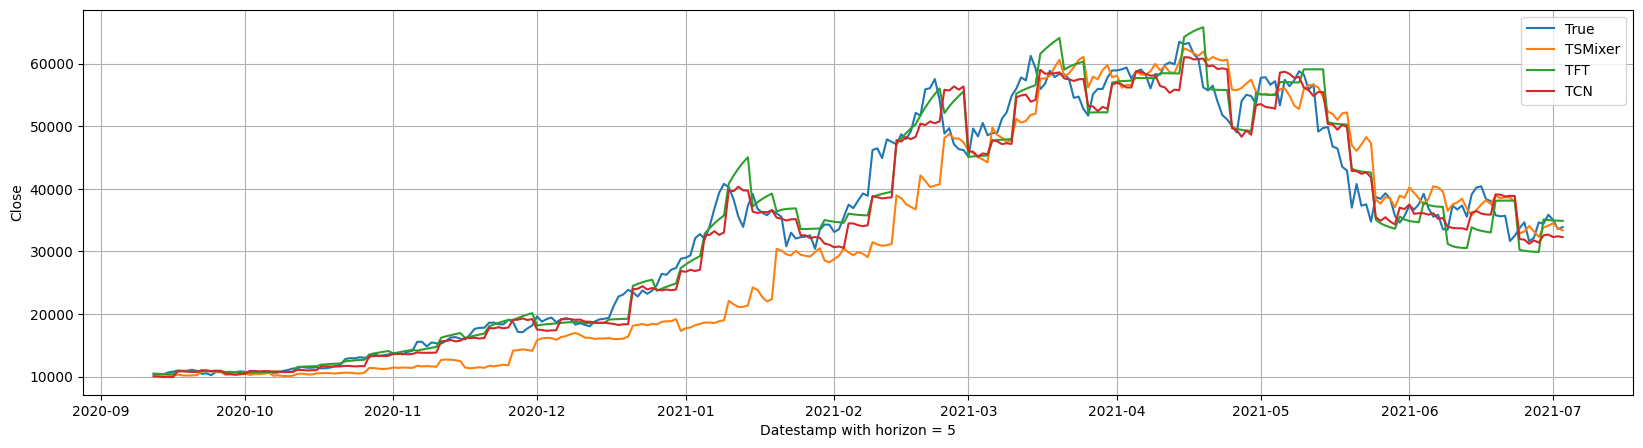

In [ ]:
df_hat = df_hat.reset_index()
df_hat = df_hat[df_hat["unique_id"] == "Close"]

df_hat_hist = df_hat_hist.reset_index()
df_hat_hist = df_hat_hist[df_hat_hist['unique_id']=='Close']

y_true = df_hat.y.values
y_true_hist = df_hat_hist.y.values
y_hat_tsmixer = df_hat['AutoTSMixer'].values

y_hat_TFT = df_hat_hist['AutoTFT'].values
y_hat_LSTM = df_hat_hist['AutoTCN'].values

print(f'MAE TSMixer: {mae(y_hat_tsmixer, y_true):.3f}')
print(f'MSE TSMixer: {mse(y_hat_tsmixer, y_true):.3f}')
print(f'MAE TFT: {mae(y_hat_TFT, y_true_hist):.3f}')
print(f'MSE TFT: {mse(y_hat_TFT, y_true_hist):.3f}')
print(f'MAE TCN: {mae(y_hat_LSTM, y_true_hist):.3f}')
print(f'MSE TCN: {mse(y_hat_LSTM, y_true_hist):.3f}')

nf.save(path='/content/drive/MyDrive/Colab Notebooks/checkpoints',
        model_index=None,
        overwrite=True,
        save_dataset=True)


Y_plot = df_hat[df_hat['unique_id']=='Close']
cutoffs = df_hat['cutoff'].unique()[::horizon]
Y_plot = Y_plot[df_hat['cutoff'].isin(cutoffs)]

Y_plot_hist = df_hat_hist[df_hat_hist['unique_id']=='Close']
cutoffs_hist = df_hat_hist['cutoff'].unique()[::horizon]
Y_plot_hist = Y_plot_hist[df_hat_hist['cutoff'].isin(cutoffs_hist)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['AutoTSMixer'], label='TSMixer')
plt.plot(Y_plot['ds'], Y_plot_hist['AutoTFT'], label='TFT')
plt.plot(Y_plot['ds'], Y_plot_hist['AutoTCN'], label='TCN')
plt.xlabel(f'Datestamp with horizon = {horizon}')
plt.ylabel('Close')
plt.grid()
plt.legend()
plt.show()
